In [1]:
%matplotlib inline

import gym
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
from torch.autograd import Variable

from utils import grid_from_state, process_state
from tutorial import select_action, calculate_epsilon
from models import DQN
from memory import ReplayMemory
from atari_wrappers import wrap_deepmind

## Double Q learning
- https://arxiv.org/pdf/1509.06461.pdf
- Stabilizes training and sometimes improves performance. 
- ~5 lines of code

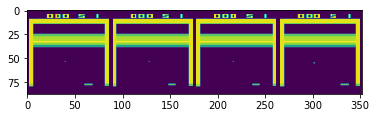

In [2]:
env = gym.make('Breakout-v0')
env = wrap_deepmind(env, frame_stack=True)
_ = env.reset()
action = env.action_space.sample()
state, reward, _, _ = env.step(action)  # carry out action/observe reward
next_state, _, _, _ = env.step(env.action_space.sample())  # carry out action/observe reward

plt.imshow(grid_from_state(state));

use a second DQN to compute `next_q_values` The target network,
with parameters θ−, is the same as the online network except
that its parameters are copied every τ steps from the online network,
so that then θ−t = θt, and kept fixed on all other steps.

- it is common to copy params every 1k-10k frames

## q network and target network are the same

In [3]:
q_network = DQN(env.action_space.n) # initialize action-value function Q with random weights
target_network = DQN(env.action_space.n)

In [4]:
q_network

DQN(
  (conv1): Conv2d (4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d (32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc4): Linear(in_features=3136, out_features=512)
  (fc5): Linear(in_features=512, out_features=4)
)

In [5]:
target_network

DQN(
  (conv1): Conv2d (4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d (32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc4): Linear(in_features=3136, out_features=512)
  (fc5): Linear(in_features=512, out_features=4)
)

## New target calculation process
![doubledqn](assets/doubleq.png)

In [6]:
s = Variable(process_state(state))
r = Variable(torch.Tensor([reward]))
s2 = Variable(process_state(next_state))

In [7]:
q_values = q_network(s)[:, action] # q vals for action we took

In [8]:
target_actions = q_network(s2).max(dim=1)[1]
next_q_values = target_network(s2)[range(len(target_actions)), target_actions]
targets = r + (0.99 * next_q_values)

## sync process, every 1-10k steps

In [29]:
dqn_params = q_network.state_dict()
target_network.load_state_dict(dqn_params)

## new training loop (single episode)

In [10]:
# hyper params

batch_size = 32
gamma = 0.99
learning_rate =1e-4
capacity=10000
sync_interval=1000 # new parameter t from paper

In [11]:
memory = ReplayMemory(capacity) # initialize replay memory
q_network = DQN(env.action_space.n).cuda() # initialize action-value function Q with random weights
target_network = DQN(env.action_space.n).cuda() # init target network

optimizer = Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.SmoothL1Loss()
state = env.reset() # observe initial state

current_step = 0

while True:
    env.render() # so we can watch!
    action = select_action(q_network, state, env, calculate_epsilon(current_step)) # select action
    next_state, reward, done, info = env.step(action)  # carry out action/observe reward
    # store experience s, a, r, s' in replay memory
    memory.add(state, action, reward, next_state, done)

    # sample random transitions
    states, actions, rewards, next_states, done_mask = memory.sample(batch_size)
    
    # prepare batch
    states = Variable(states).cuda()
    next_states = Variable(next_states).cuda()
    rewards = Variable(rewards).cuda()
    done_mask = Variable(done_mask).cuda()

    # calculate target
    # find next Q values and set Q values for done states to 0
    
    ### DOUBLE Q LEARNING
    target_actions = q_network(next_states).max(dim=1)[1]
    next_q_values = target_network(next_states)[range(len(target_actions)), target_actions].detach() * done_mask
    ### END DOUBLE Q LEARNING
    
    # calculate targets = rewards + (gamma * next_Q_values)
    targets = rewards + (gamma * next_q_values)

    q_values = q_network(states)[range(len(actions)), actions]  # select only Q values for actions we took
    
    # train network
    loss = criterion(q_values, targets) # smooth l1 loss
    optimizer.zero_grad()
    loss.backward()
    
    # gradient clipping to prevent exploding gradient
    for param in q_network.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    state = next_state # move to next state
    current_step += 1
    
    ### DDQN sync
    if current_step % sync_interval == 0:
            dqn_params = q_network.state_dict()
            target_network.load_state_dict(dqn_params)
    if done:
        break

env.close()